## Final Project Submission

Please fill out:
* Student name: Esra Guzel
* Student pace: Full time
* Scheduled project review date/time:
* Instructor name: Abhineet Kulkarni
* Blog post URL: 

In this project, the Chest X-Ray Images (Pneumonia) dataset on Kaggle is chosen to work on. The aim of this project is to predict whether the X-Ray images are belong to a healthy person or a pneumonia patient by applying neural network models. 

In [31]:
import os, shutil
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
import tensorflow as tf
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras.utils import plot_model
from keras import losses
from sklearn.utils import shuffle

from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import glorot_uniform
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.losses import binary_crossentropy
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from matplotlib import image
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import itertools
from keras.utils import plot_model
from IPython.display import Image    

np.random.seed(123)

## Obtaining the data 

The data has 5860 training images, divided into 3 fold of train, validation and test. The data is also highly imbalanced that number of pneumonia images exceeds the number of normal images nearly 3 times. 

The dataset obtained from Kaggle manually redistributed that train set contains 70%, test and validation and test sets contains 15% of the data and balanced shares of normal and pneumonia images. 

In [32]:
new_dir = 'split/'


In [33]:
train_folder = os.path.join(new_dir, 'train')
test_folder = os.path.join(new_dir, 'test')
val_folder = os.path.join(new_dir, 'val')

## Scrubbing the data 

The images are normalized by dividing into 255 since all pixel values are always between 0 and 255.

In [34]:
# get all the data in the directory split/test (883 images), and reshape them
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(64, 64), batch_size = 876) 

# get all the data in the directory split/validation (872 images), and reshape them
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(64, 64), batch_size = 877)

# get all the data in the directory split/train (4101 images), and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(64, 64), batch_size=4103)  

Found 876 images belonging to 2 classes.
Found 877 images belonging to 2 classes.
Found 4103 images belonging to 2 classes.


In [35]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

##  Exploring the data 

In [36]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

Number of training samples: 4103
Number of testing samples: 876
Number of validation samples: 877
train_images shape: (4103, 64, 64, 3)
train_labels shape: (4103, 2)
test_images shape: (876, 64, 64, 3)
test_labels shape: (876, 2)
val_images shape: (877, 64, 64, 3)
val_labels shape: (877, 2)


Label: [0. 1.]


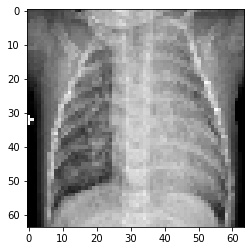

In [37]:
sample_image = train_images[0]
sample_label =train_labels[0]
display(plt.imshow(sample_image));
print('Label: {}'.format(sample_label))

In [38]:
sample_image

array([[[0.2627451 , 0.2627451 , 0.2627451 ],
        [0.27058825, 0.27058825, 0.27058825],
        [0.28627452, 0.28627452, 0.28627452],
        ...,
        [0.23137257, 0.23137257, 0.23137257],
        [0.2901961 , 0.2901961 , 0.2901961 ],
        [0.2784314 , 0.2784314 , 0.2784314 ]],

       [[0.27450982, 0.27450982, 0.27450982],
        [0.30980393, 0.30980393, 0.30980393],
        [0.31764707, 0.31764707, 0.31764707],
        ...,
        [0.28235295, 0.28235295, 0.28235295],
        [0.3019608 , 0.3019608 , 0.3019608 ],
        [0.3019608 , 0.3019608 , 0.3019608 ]],

       [[0.2627451 , 0.2627451 , 0.2627451 ],
        [0.3019608 , 0.3019608 , 0.3019608 ],
        [0.32941177, 0.32941177, 0.32941177],
        ...,
        [0.37647063, 0.37647063, 0.37647063],
        [0.37647063, 0.37647063, 0.37647063],
        [0.3803922 , 0.3803922 , 0.3803922 ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [39]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(4103, 12288)
(876, 12288)
(877, 12288)


In [10]:
train_y = np.reshape(train_labels[:,0], (4103,1))
test_y = np.reshape(test_labels[:,0], (876,1))
val_y = np.reshape(val_labels[:,0], (877,1))

### Helper functions 

In [11]:
# Run this lines to flush py files cache
%reload_ext autoreload
%autoreload 2

# Import helper functions
from helper_functions import print_accuracy_report
from helper_functions import plot_con_matrix
from helper_functions import visualize_training_results

## Modelling the data

### Baseline Model 

In [12]:
from keras import models
from keras import layers
np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(12288,))) 
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
optimizer = keras.optimizers.Adam(lr=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                122890    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 122,951
Trainable params: 122,951
Non-trainable params: 0
_________________________________________________________________


In [14]:

history = model.fit(train_img,
                    train_y,
                    epochs=60,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 4103 samples, validate on 877 samples
Epoch 1/60
4103/4103 [==============================] - 1s 146us/step - loss: 0.5549 - acc: 0.7295 - val_loss: 0.5043 - val_acc: 0.7389
Epoch 2/60
4103/4103 [==============================] - 1s 126us/step - loss: 0.4566 - acc: 0.7650 - val_loss: 0.4336 - val_acc: 0.7662
Epoch 3/60
4103/4103 [==============================] - 0s 89us/step - loss: 0.3998 - acc: 0.8228 - val_loss: 0.3896 - val_acc: 0.8153
Epoch 4/60
4103/4103 [==============================] - 0s 114us/step - loss: 0.3643 - acc: 0.8530 - val_loss: 0.3590 - val_acc: 0.8461
Epoch 5/60
4103/4103 [==============================] - 0s 93us/step - loss: 0.3389 - acc: 0.8684 - val_loss: 0.3335 - val_acc: 0.8757
Epoch 6/60
4103/4103 [==============================] - 0s 78us/step - loss: 0.3181 - acc: 0.8813 - val_loss: 0.3192 - val_acc: 0.8597
Epoch 7/60
4103/4103 [==============================] - 0s 73us/step - loss: 0.3011 - acc: 0.8918 - val_loss: 0.3022 - val_acc: 0.8746
Epoch

In [15]:
results_train = model.evaluate(train_img, train_y)

4103/4103 [==============================] - 0s 28us/step


In [16]:
results_test = model.evaluate(test_img, test_y)

876/876 [==============================] - 0s 32us/step


In [17]:
results_train

[0.14936533737805102, 0.9451620765293688]

In [18]:
results_test

[0.3281972039848158, 0.873287671505044]

In [19]:
y_pred = model.predict(test_img)
y_pred = np.rint(y_pred)

print(classification_report(test_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       640
           1       0.96      0.56      0.70       236

    accuracy                           0.87       876
   macro avg       0.91      0.77      0.81       876
weighted avg       0.88      0.87      0.86       876



While the baseline model has 88% percent accuracy, the recall score for pneumonia is really low. Here it is observed that for medical field accuracy score isn't enough and sometimes misleading. 

While precision is the ratio of correct positive predictions to the total predicted positives, recall is the ratio of correct positive predictions to the total positives. In our case we will be also targeting higher recall scores for both pneumonia and normal cases besides accuracy. 


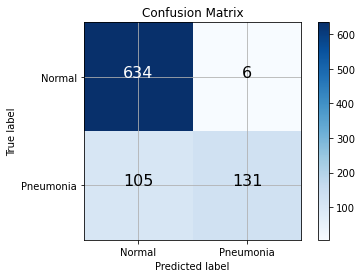

In [20]:
class_names = ['Normal','Pneumonia']

y_pred = model.predict(test_img)
y_pred = np.rint(y_pred)
    
plt.grid(b=None)
cmap=plt.cm.Blues  
cnf_matrix = confusion_matrix(test_y, y_pred)
plt.imshow(cnf_matrix, cmap=cmap) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
    
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 fontsize=16,
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

    
plt.colorbar()
plt.show()

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

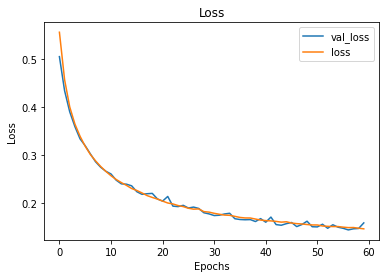

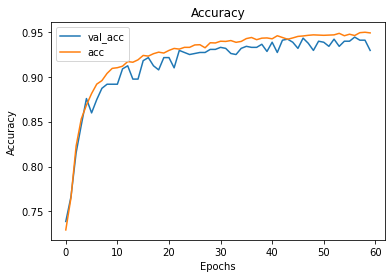

In [22]:
visualize_training_results(history)

### Regularization with dropout

In [23]:
model = models.Sequential()
# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
model.add(layers.Dropout(0.3, input_shape=(12288,)))

# Add the first hidden layer
model.add(layers.Dense(16, activation='relu'))

# Implement dropout to the first hidden layer 
model.add(layers.Dropout(0.3))

# Add the second hidden layer
model.add(layers.Dense(10, activation='relu'))

# Implement dropout to the second hidden layer 
model.add(layers.Dropout(0.3))


# Add the output layer
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(lr=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 12288)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                196624    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 196,805
Trainable params: 196,805
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(train_img,
                    train_y,
                    epochs=80,
                    batch_size=32,
                    validation_data=(val_img, val_y))

Train on 4103 samples, validate on 877 samples
Epoch 1/80
4103/4103 [==============================] - 1s 196us/step - loss: 0.7068 - acc: 0.5535 - val_loss: 0.6928 - val_acc: 0.7298
Epoch 2/80
4103/4103 [==============================] - 1s 141us/step - loss: 0.6926 - acc: 0.7141 - val_loss: 0.6924 - val_acc: 0.7298
Epoch 3/80
4103/4103 [==============================] - 1s 138us/step - loss: 0.6922 - acc: 0.7290 - val_loss: 0.6920 - val_acc: 0.7298
Epoch 4/80
4103/4103 [==============================] - 1s 137us/step - loss: 0.6919 - acc: 0.7251 - val_loss: 0.6916 - val_acc: 0.7298
Epoch 5/80
4103/4103 [==============================] - 1s 138us/step - loss: 0.6911 - acc: 0.7341 - val_loss: 0.6911 - val_acc: 0.7355
Epoch 6/80
4103/4103 [==============================] - 1s 142us/step - loss: 0.6898 - acc: 0.7375 - val_loss: 0.6894 - val_acc: 0.7685
Epoch 7/80
4103/4103 [==============================] - 1s 138us/step - loss: 0.6875 - acc: 0.7446 - val_loss: 0.6879 - val_acc: 0.7799
E

In [25]:
results_train = model.evaluate(train_img, train_y)
results_test = model.evaluate(test_img, test_y)
print(results_train)
print(results_test)

876/876 [==============================] - 0s 37us/step
[0.5416299235652257, 0.9249329758713136]
[0.5771544020469874, 0.8858447488584474]


In [26]:
y_pred = model.predict(test_img)
y_pred = np.rint(y_pred)

print(classification_report(test_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92       640
           1       0.84      0.71      0.77       236

    accuracy                           0.89       876
   macro avg       0.87      0.83      0.85       876
weighted avg       0.88      0.89      0.88       876



After applying dropout no progress observed in terms of recall and accuracy scores. 

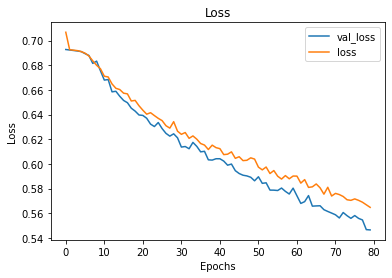

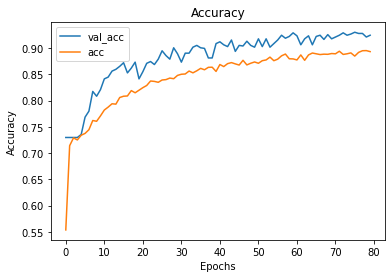

In [27]:
visualize_training_results(history)

###  CNN model

At this point, Convolutional Neural Networks (CNNs) is applied to analyze and classify the images since it can learn both small and larger patterns. First a basic then a more complicated model is applied to compare and analyze models performance. 

In [28]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
__________

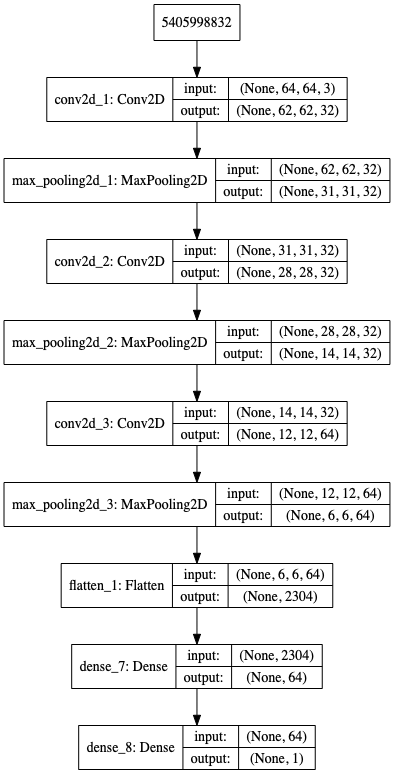

In [30]:
from keras.utils import plot_model
from IPython.display import Image 

file_name = 'cnn1_model.png'
plot_model(model, show_shapes=True, show_layer_names=True, to_file=file_name)
Image(file_name)

In [40]:
history = model.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=32,
                    validation_data=(val_images, val_y))

Train on 4103 samples, validate on 877 samples
Epoch 1/30
4103/4103 [==============================] - 17s 4ms/step - loss: 0.5689 - acc: 0.7295 - val_loss: 0.5507 - val_acc: 0.7298
Epoch 2/30
4103/4103 [==============================] - 15s 4ms/step - loss: 0.5065 - acc: 0.7321 - val_loss: 0.4806 - val_acc: 0.7480
Epoch 3/30
4103/4103 [==============================] - 14s 4ms/step - loss: 0.4381 - acc: 0.7841 - val_loss: 0.4244 - val_acc: 0.7651
Epoch 4/30
4103/4103 [==============================] - 16s 4ms/step - loss: 0.3804 - acc: 0.8411 - val_loss: 0.3676 - val_acc: 0.8483
Epoch 5/30
4103/4103 [==============================] - 15s 4ms/step - loss: 0.3353 - acc: 0.8686 - val_loss: 0.3349 - val_acc: 0.8575
Epoch 6/30
4103/4103 [==============================] - 15s 4ms/step - loss: 0.3007 - acc: 0.8872 - val_loss: 0.3094 - val_acc: 0.8814
Epoch 7/30
4103/4103 [==============================] - 14s 3ms/step - loss: 0.2812 - acc: 0.8952 - val_loss: 0.2908 - val_acc: 0.8860
Epoch 8/

In [41]:
from keras.utils import plot_model
plot_model(model)

In [42]:
results_train = model.evaluate(train_images, train_y)
results_test = model.evaluate(test_images, test_y)
print(results_train)
print(results_test)

876/876 [==============================] - 1s 926us/step
[0.16229616584587236, 0.9419936631732878]
[0.2564518625197345, 0.9029680368018477]


In [43]:
y_pred = model.predict(test_images)
y_pred = np.rint(y_pred)

print(classification_report(test_y, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       640
           1       0.92      0.70      0.80       236

    accuracy                           0.90       876
   macro avg       0.91      0.84      0.87       876
weighted avg       0.90      0.90      0.90       876



With a basic CNN model, sensitivity (recall score for pneumonia patients) increases by 0.3 points while the overall accuracy level remains the same. The model detect the healthy patients by 98%, missed 15 healthy person out of 640. However, out of 236 pneumonia patients the model just predicted 77 correctly. 

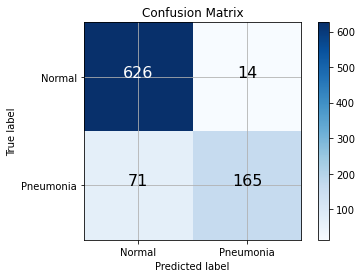

In [44]:
import matplotlib.pyplot as plt


class_names = ['Normal','Pneumonia']

y_pred = model.predict(test_images)
y_pred = np.rint(y_pred)
    
plt.grid(b=None)
cmap=plt.cm.Blues  
cnf_matrix = confusion_matrix(test_y, y_pred)
plt.imshow(cnf_matrix, cmap=cmap) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
    
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 fontsize=16,
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

    
plt.colorbar()
plt.show()

### CNN model 2.0 

In [45]:

SEED = 1234
batch_size = 64
v_batch_size = 64
input_size = (32, 32)
input_shape = input_size + (3, )

train_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=input_size,
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size=input_size,
    batch_size=v_batch_size,
    class_mode='binary')

Found 4103 images belonging to 2 classes.
Found 877 images belonging to 2 classes.


In [46]:
model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=input_shape, kernel_initializer=glorot_uniform(seed=SEED)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), kernel_regularizer=l2(0.01), kernel_initializer=glorot_uniform(seed=SEED)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), kernel_regularizer=l2(0.01), kernel_initializer=glorot_uniform(seed=SEED)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(rate=0.3, seed=SEED))

model.add(Flatten())
model.add(Dense(450, kernel_regularizer=l2(0.01), kernel_initializer=glorot_uniform(seed=SEED)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=SEED)))

model.compile(optimizer=SGD(lr=0.01, nesterov=True),
              loss=binary_crossentropy,
              metrics=['accuracy'])


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 13, 13, 32)        0         
__________

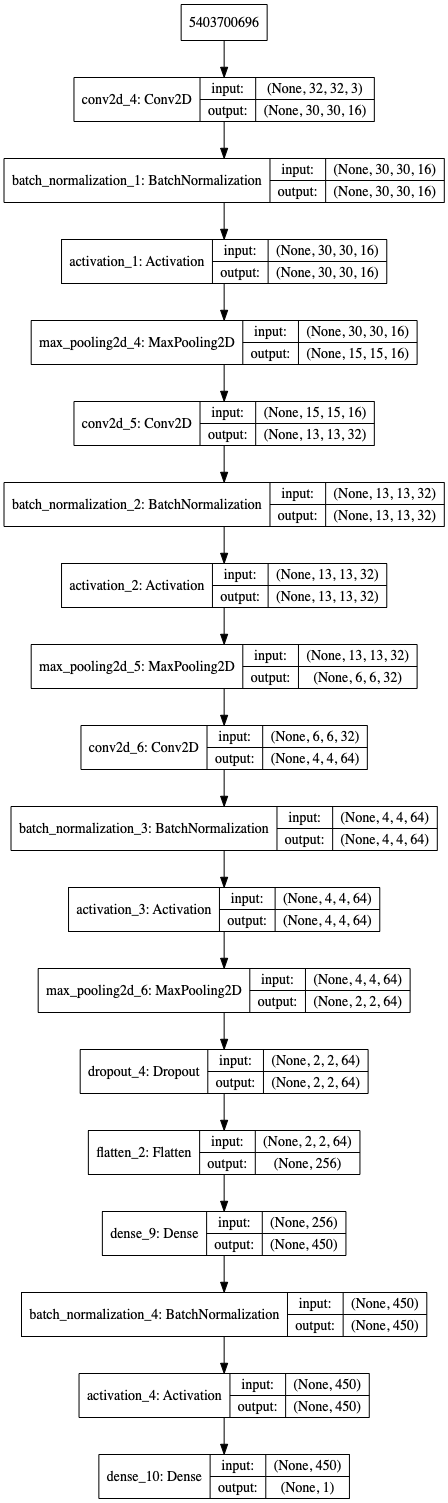

In [47]:
from keras.utils import plot_model
from IPython.display import Image 

file_name = 'cnn_model.png'
plot_model(model, show_shapes=True, show_layer_names=True, to_file=file_name)
Image(file_name)

In [48]:
# Defining callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    mode='auto',
    min_lr=0.0001)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto')
model_checkpoint = ModelCheckpoint(
    filepath='weights.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto')


In [49]:
# Fitting the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=50,
    shuffle=False,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // v_batch_size,
    callbacks=[reduce_lr, early_stopping, model_checkpoint])


model.load_weights('weights.h5')
model.save('pneumonia-chest-x-ray-cnn.h5')

Epoch 1/50
64/64 [==============================] - 42s 654ms/step - loss: 4.1859 - acc: 0.8481 - val_loss: 4.1063 - val_acc: 0.8522

Epoch 00001: val_loss improved from inf to 4.10625, saving model to weights.h5
Epoch 2/50
64/64 [==============================] - 49s 759ms/step - loss: 3.9884 - acc: 0.8947 - val_loss: 4.0355 - val_acc: 0.8266

Epoch 00002: val_loss improved from 4.10625 to 4.03553, saving model to weights.h5
Epoch 3/50
64/64 [==============================] - 46s 722ms/step - loss: 3.8563 - acc: 0.9187 - val_loss: 3.7636 - val_acc: 0.9373

Epoch 00003: val_loss improved from 4.03553 to 3.76358, saving model to weights.h5
Epoch 4/50
64/64 [==============================] - 46s 726ms/step - loss: 3.7527 - acc: 0.9275 - val_loss: 3.8463 - val_acc: 0.8635

Epoch 00004: val_loss did not improve from 3.76358
Epoch 5/50
64/64 [==============================] - 47s 727ms/step - loss: 3.6351 - acc: 0.9387 - val_loss: 3.5836 - val_acc: 0.9299

Epoch 00005: val_loss improved fro


Epoch 00040: val_loss improved from 1.62269 to 1.52947, saving model to weights.h5
Epoch 41/50
64/64 [==============================] - 42s 663ms/step - loss: 1.4515 - acc: 0.9858 - val_loss: 1.4639 - val_acc: 0.9729

Epoch 00041: val_loss improved from 1.52947 to 1.46392, saving model to weights.h5
Epoch 42/50
64/64 [==============================] - 42s 649ms/step - loss: 1.4333 - acc: 0.9871 - val_loss: 1.4362 - val_acc: 0.9877

Epoch 00042: val_loss improved from 1.46392 to 1.43620, saving model to weights.h5
Epoch 43/50
64/64 [==============================] - 39s 617ms/step - loss: 1.4153 - acc: 0.9863 - val_loss: 1.4593 - val_acc: 0.9663

Epoch 00043: val_loss did not improve from 1.43620
Epoch 44/50
64/64 [==============================] - 44s 690ms/step - loss: 1.3882 - acc: 0.9927 - val_loss: 1.4979 - val_acc: 0.9471

Epoch 00044: val_loss did not improve from 1.43620
Epoch 45/50
64/64 [==============================] - 40s 617ms/step - loss: 1.3736 - acc: 0.9897 - val_loss:

In [50]:
# Predict classes for test images 
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=input_size,
    shuffle=False,
    batch_size=v_batch_size,
    class_mode='binary')
cnn_test_score = model.evaluate_generator(
    test_generator,
    steps=test_generator.n // v_batch_size)

print("Test set:\n loss: %.4f, accuracy: %.4f" %
      (cnn_test_score[0], cnn_test_score[1]))

Found 876 images belonging to 2 classes.
Test set:
 loss: 1.5242, accuracy: 0.9111


In [51]:
y_true=test_generator.classes

y_pred = model.predict_generator(test_generator)
y_pred = np.rint(y_pred)

print(classification_report(y_true, y_pred, labels=[0,1]))


              precision    recall  f1-score   support

           0       0.88      0.78      0.83       236
           1       0.92      0.96      0.94       640

    accuracy                           0.91       876
   macro avg       0.90      0.87      0.89       876
weighted avg       0.91      0.91      0.91       876



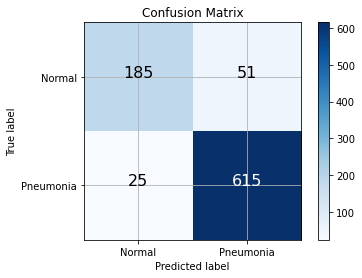

In [52]:
import matplotlib.pyplot as plt


class_names = ['Normal','Pneumonia']

y_true=test_generator.classes
y_pred = model.predict_generator(test_generator)
y_pred = np.rint(y_pred)
    
plt.grid(b=None)
cmap=plt.cm.Blues  
cnf_matrix = confusion_matrix(y_true, y_pred)
plt.imshow(cnf_matrix, cmap=cmap) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
    
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 fontsize=16,
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

    
plt.colorbar()
plt.show()

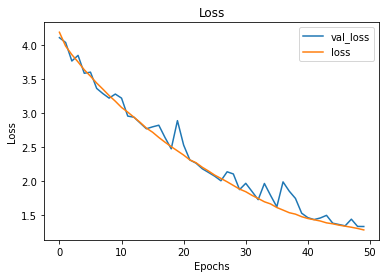

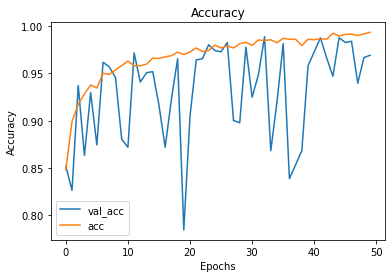

In [53]:
visualize_training_results(history)

### Transfer learning

#### Feature extraction

In [ ]:
import functools
import operator

#Transfer learning - Xception (88MB)
model_dict = {}
model_name = "Xception"
input_size = (299, 299)
features_dim = [10, 10, 2048]

model_dict['object'] = Xception
model_dict['input_size'] = input_size
model_dict['input_shape'] = input_size + (3, )
model_dict['features_dim'] = features_dim
model_dict['dense_input_dim'] = functools.reduce(operator.mul, features_dim, 1)
model_dict['weights_filename'] = model_name.lower() + '_weights.h5'
model_dict['model_filename'] = 'pneumonia-chest-x-ray-' + model_name.lower() + '.h5'
model_dict['batch_size'] = 128

In [ ]:
n_train = train_img.shape[0]
n_test = test_img.shape[0]
n_val = val_img.shape[0]

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

def extract_features(model_dict, directory, sample_count):
    
    batch_size = model_dict['batch_size']
    shape = tuple([sample_count] + model_dict['features_dim'])
    features = np.zeros(shape=shape)
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=model_dict['input_size'],
        batch_size=batch_size,
        class_mode='binary')
    
    base_model = model_dict['object'](
        input_shape=model_dict['input_shape'],
        weights='imagenet',
        include_top=False)
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = base_model.predict(inputs_batch)
        features[i * batch_size:(i + 1) * batch_size] = features_batch
        labels[i * batch_size:(i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels


train_features, train_labels = extract_features(model_dict, train_folder, n_train)
validation_features, validation_labels = extract_features(model_dict, val_folder, n_val)
test_features, test_labels = extract_features(model_dict, test_folder, n_test)

In [ ]:
train_features = np.reshape(train_features, (n_train, model_dict['dense_input_dim']))
validation_features = np.reshape(validation_features, (n_val, model_dict['dense_input_dim']))
test_features = np.reshape(test_features, (n_test, model_dict['dense_input_dim']))

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=model_dict['dense_input_dim']))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=Adam(lr=0.00001),
    loss=binary_crossentropy,
    metrics=['accuracy'])

model_checkpoint = ModelCheckpoint(
    filepath=model_dict['weights_filename'],
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto')

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='auto')

model. summary()

In [ ]:
file_name = 'tl_model.png'
plot_model(model, show_shapes=True, show_layer_names=True, to_file=file_name)
Image(file_name)

In [ ]:
history = model.fit(
    train_features,
    train_labels,
    epochs=50,
    batch_size=model_dict['batch_size'],
    validation_data=(validation_features, validation_labels),
    callbacks=[early_stopping, model_checkpoint])
model.load_weights(model_dict['weights_filename'])
model.save(model_dict['model_filename'])


In [ ]:
t_batch_size = 64

# Predict classes for test images 
test_score = model.evaluate(
    test_features, 
    test_labels,
    steps= n_test // t_batch_size)

test_score

In [ ]:
# Get numerical predictions for test set images 
predictions = model.predict(
    test_features,
    batch_size= n_test // t_batch_size)

# True and predicted labels 
pred_labels = [1 if p > 0.5 else 0 for p in predictions.ravel()]

# Classification metrics
print(classification_report(
        test_labels,
        pred_labels,
        target_names=['normal', 'pneumonia']))

In [ ]:
import matplotlib.pyplot as plt


class_names = ['Normal','Pneumonia']

y_pred = model.predict(test_features)
y_pred = np.rint(y_pred)
    
plt.grid(b=None)
cmap=plt.cm.Blues  
cnf_matrix = confusion_matrix(test_labels, y_pred)
plt.imshow(cnf_matrix, cmap=cmap) 

# Add title and axis labels
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add appropriate axis scales
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


# Add labels to each cell
thresh = cnf_matrix.max() / 2. # Used for text coloring below
    
# Here we iterate through the confusion matrix and append labels to our visualization 
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment='center',
                 fontsize=16,
                 color='white' if cnf_matrix[i, j] > thresh else 'black')

    
plt.colorbar()
plt.show()

In [ ]:
def plot_confusion_matrix(model, X, y):
    
    import matplotlib.pyplot as plt

    class_names = ['Normal','Pneumonia']

    y_pred = model.predict(X)
    y_pred = np.rint(y_pred)

    plt.grid(b=None)
    cmap=plt.cm.Blues  
    cnf_matrix = confusion_matrix(y, y_pred)
    plt.imshow(cnf_matrix, cmap=cmap) 

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)


    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below

    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     fontsize=16,
                     color='white' if cnf_matrix[i, j] > thresh else 'black')


    plt.colorbar()
    plt.show()

In [ ]:
visualize_training_results(history)

### Visualizing intermediate activations

In [ ]:
from keras import models

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]

In [ ]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

In [ ]:
from keras import models
import math 

# Extract model layer outputs
layer_outputs = [layer.output for layer in model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

## Interpretation of the data 